In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates



import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [160]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

In [161]:
dic = pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\Datos BBG.xlsx', sheet_name=5)
dic

,Index
0,Merval
1,MADX
2,FTSE MIB
3,DAX
4,UKX


In [162]:
id=1

In [163]:
data_backup=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\Datos BBG.xlsx', sheet_name=id) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
mer = data_backup
dpx = mer[['Date','PX','PXret']]
dpx = dpx[dpx['PXret'].notnull()] #generates a new DF with Price and Returns
dpx['PXdiff'] = dpx.PX.diff() # Add a column with 1st differences
dpx = dpx.set_index('Date')
#mer = mer.dropna() #is it ok to drop NaN values
#mer = mer.reset_index()
#mer = mer.drop('index', axis=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#mer=mer.set_index('Date')
mer

,Date,PX,PXret,Vol,IntR,M2R
0,1993-02-18,232.000,NaN,NaN,NaN,NaN
1,1993-02-19,233.200,0.005,NaN,NaN,NaN
2,1993-02-22,232.300,-0.004,NaN,NaN,NaN
3,1993-02-23,227.800,-0.019,NaN,NaN,NaN
4,1993-02-24,227.900,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...
7551,2022-12-23,823.570,-0.000,263787587.000,2.000,NaN
7552,2022-12-27,823.830,0.000,183924831.000,2.000,NaN
7553,2022-12-28,822.810,-0.001,181273856.000,2.000,NaN
7554,2022-12-29,828.870,0.007,193245802.000,2.000,NaN


In [165]:
#Describe the info of the df (count, mean, std, min, max, etc)
dpx.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PX,7549.000,874.028,303.371,227.800,745.470,884.430,1035.030,1724.950
PXret,7549.000,0.000,0.014,-0.140,-0.007,0.001,0.007,0.147
PXdiff,7548.000,0.078,12.220,-111.460,-5.353,0.520,5.833,137.540


In [166]:
#mer['Date'] = pd.to_datetime(mer.Date) #convert the date string into date object
#df.Date.dt.day_name() -> brings the name of the dayweek
mer.dtypes

Date     datetime64[ns]
PX              float64
PXret           float64
Vol             float64
IntR            float64
M2R             float64
dtype: object

In [167]:
#mer["PXret"] = mer.PX.pct_change(1).mul(100)
#mer["PXvolat"] = mer.PXret.abs()
#mer['PXdiff'] = mer.PX.diff()
#mer["PXlog"]=np.log(mer["PX"].values)
#mer["PXlogDif"]=mer["PXlog"].diff(1)
#mer

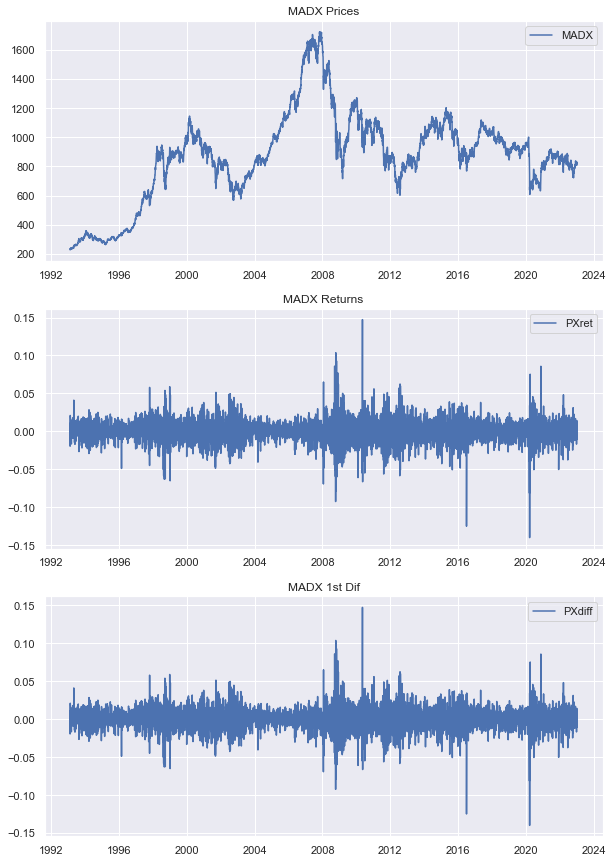

In [168]:
plt.rcParams["figure.figsize"] = (10, 15)

fig, ax = plt.subplots(3,1)


ax[0].plot(dpx.PX, label = dic.Index[id])
ax[0].set_title(dic.Index[id]+" Prices", size = 12)
ax[0].legend()

ax[1].plot(dpx.PXret, label = "PXret")
ax[1].set_title(dic.Index[id]+" Returns", size = 12)
ax[1].legend()

ax[2].plot(dpx.PXret, label = "PXdiff")
ax[2].set_title(dic.Index[id]+" 1st Dif", size = 12)
ax[2].legend()


In [169]:
# Stationarity check for PX
ADF_result = adfuller(dpx.PX)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.3240728825543027
p-value: 0.16432148049335715


In [170]:
# Stationarity check for PXret
ADF_result = adfuller(dpx.PXret)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -40.71871081300336
p-value: 0.0


In [171]:
# Stationarity check for PXdiff
ADF_result = adfuller(dpx.PXdiff[1:])
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -40.63936518627709
p-value: 0.0


In [172]:
# Data split
train = dpx[:int(0.9*len(mer))]
test = dpx[int(0.9*len(mer)):]


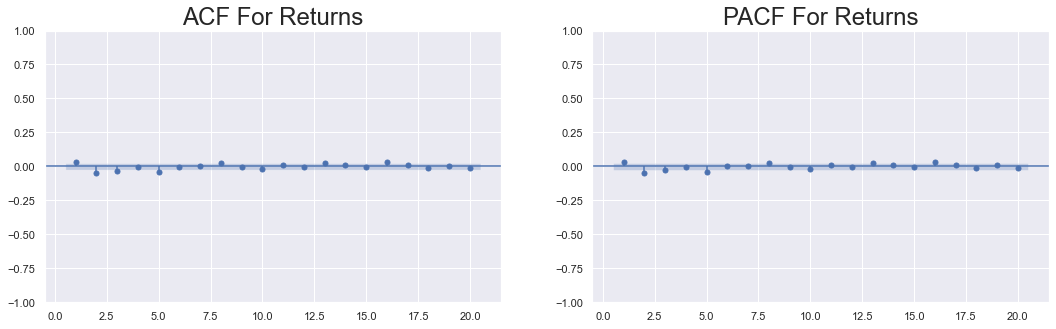

In [173]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train.PXret[1:], zero = False, lags = 20, ax = axes[0])
sgt.plot_pacf(train.PXret[1:], zero = False, lags = 20, ax = axes[1])

axes[0].set_title("ACF For Returns", size = 24)
axes[1].set_title("PACF For Returns", size = 24)

plt.show()

In [174]:
# Importing Required Package
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Model Definition
model0 = SARIMAX(train['PXret'].dropna(), order = (2, 0, 1))
# Model Training
model_fit = model0.fit()
# Summary of the model built
model_fit.summary() # for MADret ARMA(2,1) seems to be the optimal

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PXret   No. Observations:                 6800
Model:               SARIMAX(2, 0, 1)   Log Likelihood               19740.547
Date:                Tue, 10 Jan 2023   AIC                         -39473.093
Time:                        22:02:16   BIC                         -39445.794
Sample:                             0   HQIC                        -39463.673
                               - 6800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6334      0.095      6.673      0.000       0.447       0.819
ar.L2         -0.0652      0.008     -7.790      0.000      -0.082      -0.049
ma.L1         -0.6013      0.095     -6.329      0.000      -0.788      -0.415
sigma2         0.0002   1.55e-06    113.952      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             13287.41
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [175]:
#model for prediction
arma_forecast = model_fit.get_forecast(len(test.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%

#store predictions
arma_predictions_df["Predictions"] = model_fit.predict(start = test.index[0], end = test.index[-1])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
arma_predictions_df

In [ ]:
# RMSE for the Predictions
arma_rmse = np.sqrt(mean_squared_error(test["PXret"].values, arma_predictions_df["Predictions"]))

In [ ]:
# PLOTTING FORECASTS
# Set the Size of the figure
plt.rcParams["figure.figsize"] = 18, 5

# Plot the Actuals
plt.plot(test["PXret"], color = "blue", label = "Actual Values")

# Plot the Forecasts and the Confidence Intervals 
#plt.plot(arma_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper PXret"][test.index], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower PXret"][test.index], color = "green", linestyle = "--")
